## Demo with DECam data

This walkthrough uses the Burke et al. 2019 dataset, but superceeds the old Matterport Mask R-CNN implementation.

#### A few notes:

The data can be obtained following the links in the [old repository](https://github.com/burke86/astro_rcnn). The dataset directories should be re-named "test", "train", and "val".

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from detectron2.structures import BoxMode
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
from detectron2.config import LazyConfig, get_cfg

import weakref
import copy
import torch
import time
from typing import Dict, List, Optional

import imgaug.augmenters as iaa


from astropy.io import fits
import glob

import deepdisc.astrodet.astrodet as toolkit
from deepdisc.astrodet import detectron as detectron_addons

from deepdisc.data_format.file_io import DDLoader, convert_to_json
from deepdisc.data_format.annotation_functions.annotate_dc2 import annotate_dc2

In [2]:
# Print some versions so we know what works
print(torch.__version__)
print(detectron2.__version__)

1.13.0
0.6


In [3]:
# Prettify the plotting
from deepdisc.astrodet.astrodet import set_mpl_style

set_mpl_style()

In [4]:
# Todo: change the dirpath here
#dirpath = "/home/shared/hsc/decam/decam_data/"  # Path to dataset
#output_dir = "/home/shared/hsc/decam/models/"


dirpath = "/home/wenyinli/wl_deepdisc/datasets/test_elp/"
output_dir = "/home/wenyinli/wl_deepdisc/datasets/test_elp/"
dataset_names = ["train", "test", "val"]

### Register Astro R-CNN dataset

For detectron2 to read the data, it must be in a dictionary format. The flexible `DDLoader` class can be used to load data from a generic directory 
structure into a user-defined output structure of metadata. Below, we iterate over each dataset and initialize a `DDLoader` instance. The `DDLoader.generate_filedict` function is used to read the directory structure and return a dictionary of file names. We can then use the `DDLoader.generate_dataset_dict` function, which
passes a user-defined annotation function along to the files, using the 
generated dictionary of filenames.

In this case, we have a pre-made annotation function for DECAM data,
`annotate_decam`, which is passed along.

However, this step can take a few minutes, and so we recommend only running it once and saving the dictionary data as a json file that can be 
read in at the beginning of your code.


In [5]:
nsamples = [1024,100,100]
dataset_dicts = {}
for i, d in enumerate(dataset_names):
    print(nsamples[i])
    filenames_dir = os.path.join(dirpath, d)+'/'
    print(filenames_dir)
    #filenames_dir = dirpath
    
    # Generate the dictionary of filenames
    decam_loader = DDLoader().generate_filedict(filenames_dir, 
                                                ['u','g','r','i','z','y'], 
                                                "image_*.fits", 
                                                "masks.fits", 
                                                subdirs=True, 
                                                filt_loc=-6, 
                                                n_samples=nsamples[i])
    
    # Register the dataset generator functions
    DatasetCatalog.register("astro_" + d, lambda: decam_loader.generate_dataset_dict(annotate_dc2, filters=False).get_dataset())
    MetadataCatalog.get("astro_" + d).set(thing_classes=["galaxy"], things_colors=["blue"])
    dataset_dicts[d] = decam_loader.generate_dataset_dict(annotate_dc2, filters=['U','G','R','I','Z','Y']).get_dataset()
astro_metadata = MetadataCatalog.get("astro_train")


# for i, d in enumerate(dataset_names):
#for i, d in enumerate(dataset_names):
#    print(f"Loading {d}")
#    dataset_dicts[d] = decam_loader.generate_dataset_dict(annotate_dc2, filters=['U','G','R','I','Z','Y']).get_dataset()

1024
/home/wenyinli/wl_deepdisc/datasets/test_elp/train/
1280
0
6
40
48
53
58
60
62
63
65
7
9
17
31
39
62
42
5
22
32
39
54
57
82
95
99
103
117
1
18
46
80
94
98
101
5
14
53
60
64
70
9
77
9
47
51
52
38
60
72
74
83
28
32
36
37
43
44
61
66
70
73
87
19
93
9
20
38
47
2
16
24
25
43
61
66
67
79
83
3
60
78
18
25
58
62
64
2
7
19
88
95
32
62
68
73
83
41
58
61
75
17
28
58
33
57
64
94
97
51
61
5
30
50
53
67
74
77
84
91
13
15
22
24
51
52
63
69
71
74
6
16
37
46
54
59
62
65
69
79
80
98
100
16
17
27
29
33
37
41
52
56
76
78
2
11
14
17
27
28
43
51
53
76
78
100
7
19
25
33
48
53
1
2
57
59
26
46
50
64
61
8
10
14
19
37
41
58
72
73
74
78
29
36
37
47
54
56
76
3
16
27
35
52
61
69
5
21
22
37
47
52
54
55
59
63
74
11
12
77
13
0
29
45
61
63
0
5
8
16
36
41
68
75
37
39
42
45
46
54
59
69
72
6
25
31
38
55
57
63
75
13
20
51
52
79
4
23
29
41
60
61
1
22
24
32
35
48
45
10
79
84
95
12
77
91
47
59
1
25
38
40
54
62
69
25
59
68
72
76
78
13
60
2
66
4
12
18
19
66
94
1
17
29
30
37
46
48
49
57
88
16
26
32
38
39
54
67
74
80
21
24
3

In [6]:
print(dataset_dicts['train'][0])

{'filename': '/home/wenyinli/wl_deepdisc/datasets/test_elp/train/3079/1,1/0/image', 'image_id': 0, 'height': 262, 'width': 262, 'annotations': [{'bbox': [153, 99, 21, 21], 'area': 441, 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[162, 103, 161, 104, 160, 104, 158, 106, 158, 107, 157, 108, 157, 110, 158, 111, 158, 112, 160, 114, 161, 114, 162, 115, 164, 115, 165, 114, 166, 114, 168, 112, 168, 111, 169, 110, 169, 108, 168, 107, 168, 106, 166, 104, 165, 104, 164, 103]], 'category_id': 0, 'redshift': 0.1713548294511357, 'obj_id': 126.0, 'mag_i': 24.869429713298217, 'shear_1': 7.0021033275136e-05, 'shear_2': -0.0006731946328446, 'convergence': -0.0009955314278455, 'et_1': 0.0051414601857926, 'et_2': 0.0048923349564583}, {'bbox': [214, 91, 21, 21], 'area': 441, 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[223, 95, 222, 96, 221, 96, 219, 98, 219, 99, 218, 100, 218, 102, 219, 103, 219, 104, 221, 106, 222, 106, 223, 107, 225, 107, 226, 106, 227, 106, 229, 104, 229, 103, 230, 1

In [7]:
trainfile = os.path.join(dirpath, "train.json")
testfile = os.path.join(dirpath, "test.json")
valfile = os.path.join(dirpath, "val.json")
convert_to_json(dataset_dicts['train'], trainfile, allow_cached=False)
convert_to_json(dataset_dicts['val'], testfile, allow_cached=False)
convert_to_json(dataset_dicts['test'], valfile, allow_cached=False)

Caching COCO format annotations at '/home/wenyinli/wl_deepdisc/datasets/test_elp/train.json' ...
Caching COCO format annotations at '/home/wenyinli/wl_deepdisc/datasets/test_elp/test.json' ...
Caching COCO format annotations at '/home/wenyinli/wl_deepdisc/datasets/test_elp/val.json' ...


In [10]:
# code snippet for unregistering if you want to change something


if "astro_train" in DatasetCatalog.list():
    print('removing astro_train')
    DatasetCatalog.remove("astro_train")
    
    
if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    
if "astro_val" in DatasetCatalog.list():
    print('removing astro_val')
    DatasetCatalog.remove("astro_val")



removing astro_train
removing astro_test
removing astro_val


Run the following hidden cells if your data is already saved in dictionary format. You will need to change file paths. If you already registered the data, you will need to run the cell above

In [5]:
# Initialize a DDLoader class, which will just be used to load existing files
json_loader = DDLoader()

trainfile = os.path.join(dirpath, "train.json")
testfile = os.path.join(dirpath, "test.json")
valfile = os.path.join(dirpath, "val.json")

DatasetCatalog.register("astro_train", lambda: json_loader.load_coco_json_file(trainfile).get_dataset())
MetadataCatalog.get("astro_train").set(thing_classes=["galaxy"])
astrotrain_metadata = MetadataCatalog.get("astro_train")  # astro_test dataset needs to exist

DatasetCatalog.register("astro_test", lambda: json_loader.load_coco_json_file(testfile).get_dataset())
MetadataCatalog.get("astro_test").set(thing_classes=["galaxy"])
astrotest_metadata = MetadataCatalog.get("astro_test")
# astro_test dataset needs to exist


DatasetCatalog.register("astro_val", lambda: json_loader.load_coco_json_file(valfile).get_dataset())
MetadataCatalog.get("astro_val").set(thing_classes=["galaxy"])
# astroval_metadata = MetadataCatalog.get("astro_val") # astro_test dataset needs to exist

namespace(name='astro_val', thing_classes=['galaxy'])

In [6]:
dataset_dicts = {}
json_loader = DDLoader()

for i, d in enumerate(dataset_names):
    print(f"Loading {d}")
    filenames_dir = os.path.join(dirpath, d)
    dataset_dicts[d] = json_loader.load_coco_json_file(filenames_dir + ".json").get_dataset()
astro_metadata = MetadataCatalog.get("astro_train")

Loading train
Loading test
Loading val


### Visualize ground truth examples

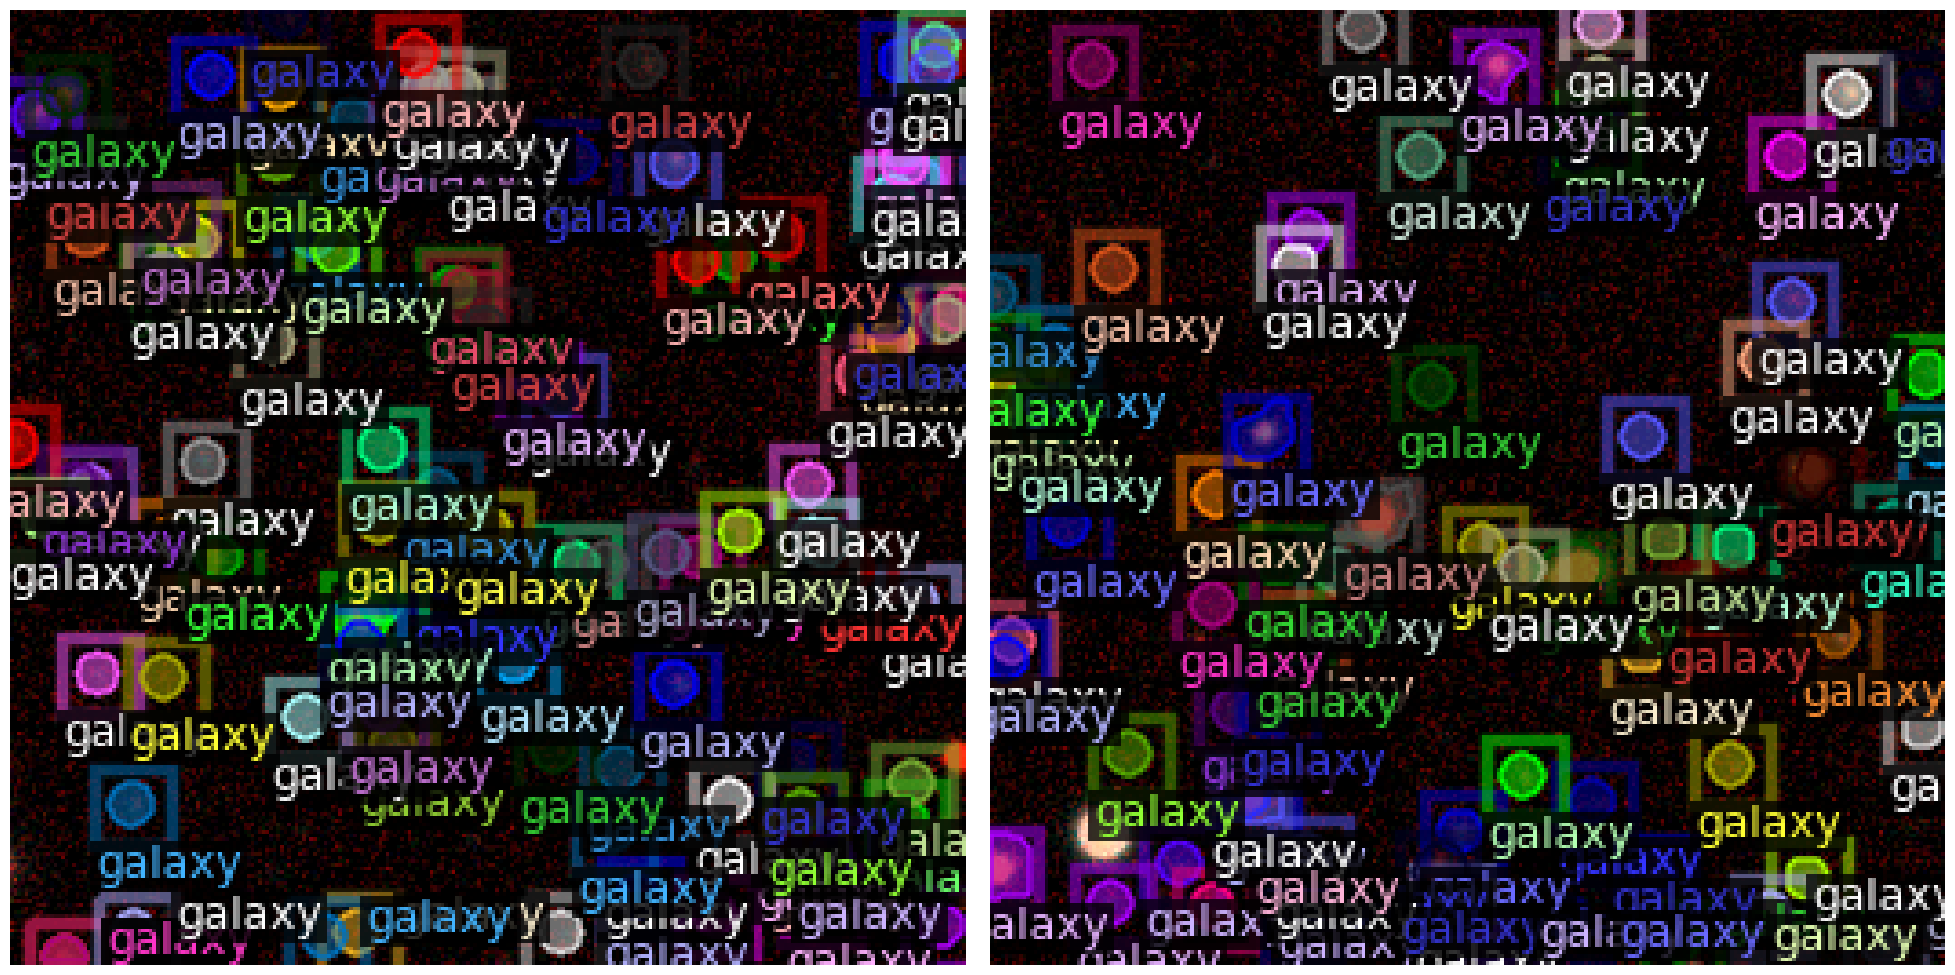

In [8]:
astro_metadata = MetadataCatalog.get("astro_train")
nsample = 2 # Number of example images to plot
fig, axs = plt.subplots(1, nsample, figsize=(10 * nsample, 10))

for i, d in enumerate(random.sample(dataset_dicts['test'], nsample)):
    # Use the Lupton scaling for better visualization
    img = toolkit.read_image_decam(d['filename'], normalize="astrolupton", stretch=1, Q=1)

    visualizer = Visualizer(img, metadata=astro_metadata)
    # Plot the figures
    out = visualizer.draw_dataset_dict(d)
    axs[i].imshow(out.get_image())
    axs[i].axis("off")
    fig.tight_layout()
    fig.show()

In [7]:
mean = np.zeros([len(dataset_dicts['test']), 6])
std = np.zeros([len(dataset_dicts['test']), 6])
for i, d in enumerate(dataset_dicts['test']):
    img = toolkit.read_image_dc2(d['filename'], normalize = 'a',stretch=1, Q=1)
    mean_per_image = img.mean(axis=(0,1))
    std_per_image = img.std(axis=(0,1))
    mean[i] = mean_per_image
    std[i] = std_per_image
print(mean.mean(axis = 0))
print(std.mean(axis = 0))

[0.06687771 0.06493237 0.09773403 0.13505115 0.17717863 0.26844701]
[3.39803446 2.23477371 2.99209274 4.05513938 5.42771314 8.59110257]


### Data Augmentations

Below, we create the function train_mapper, which takes one of the metadata dictionaries, reads in the corresponding image, and applies custom
augmentations.  It will output a new dictionary that will be fed into the model. You can see an example of the augmentations working below.

In [3]:
import imgaug.augmenters.flip as flip
import imgaug.augmenters.blur as blur


def hflip(image):
    return flip.fliplr(image)


def gaussblur(image):
    aug = iaa.GaussianBlur(sigma=(0.0, np.random.random_sample() * 4 + 2))
    return aug.augment_image(image)


def addelementwise(image):
    aug = iaa.AddElementwise((-40, 40))
    return aug.augment_image(image)

The KRandomAugmentationList class will take a list of augmentations and and randomly apply k of them

In [17]:
def train_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = toolkit.read_image_dc2(dataset_dict["filename"])
    augs = detectron_addons.KRandomAugmentationList(
        [
            # my custom augs
            T.RandomRotation([-90, 90, 180], sample_style="choice"),
            T.RandomFlip(prob=0.5),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            detectron_addons.CustomAug(gaussblur, prob=1.0),
            #detectron_addons.CustomAug(addelementwise, prob=1.0),
        ],
        k=-1,
    )

    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    instances = utils.annotations_to_instances(annos, image.shape[1:])
    instances.set("shear_1", torch.tensor([annos[i]["shear_1"] for i in range(len(annos))]))
    instances.set("shear_2", torch.tensor([annos[i]["shear_2"] for i in range(len(annos))]))
    instances.set("convergence", torch.tensor([annos[i]["convergence"] for i in range(len(annos))]))
    instances.set("redshift", torch.tensor([annos[i]["redshift"] for i in range(len(annos))]))
    return {
        # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 262,
        "width": 262,
        "image_id": dataset_dict["image_id"],
        "instances": instances,
    }

Plot the original and augmented image

NameError: name 'filename' is not defined

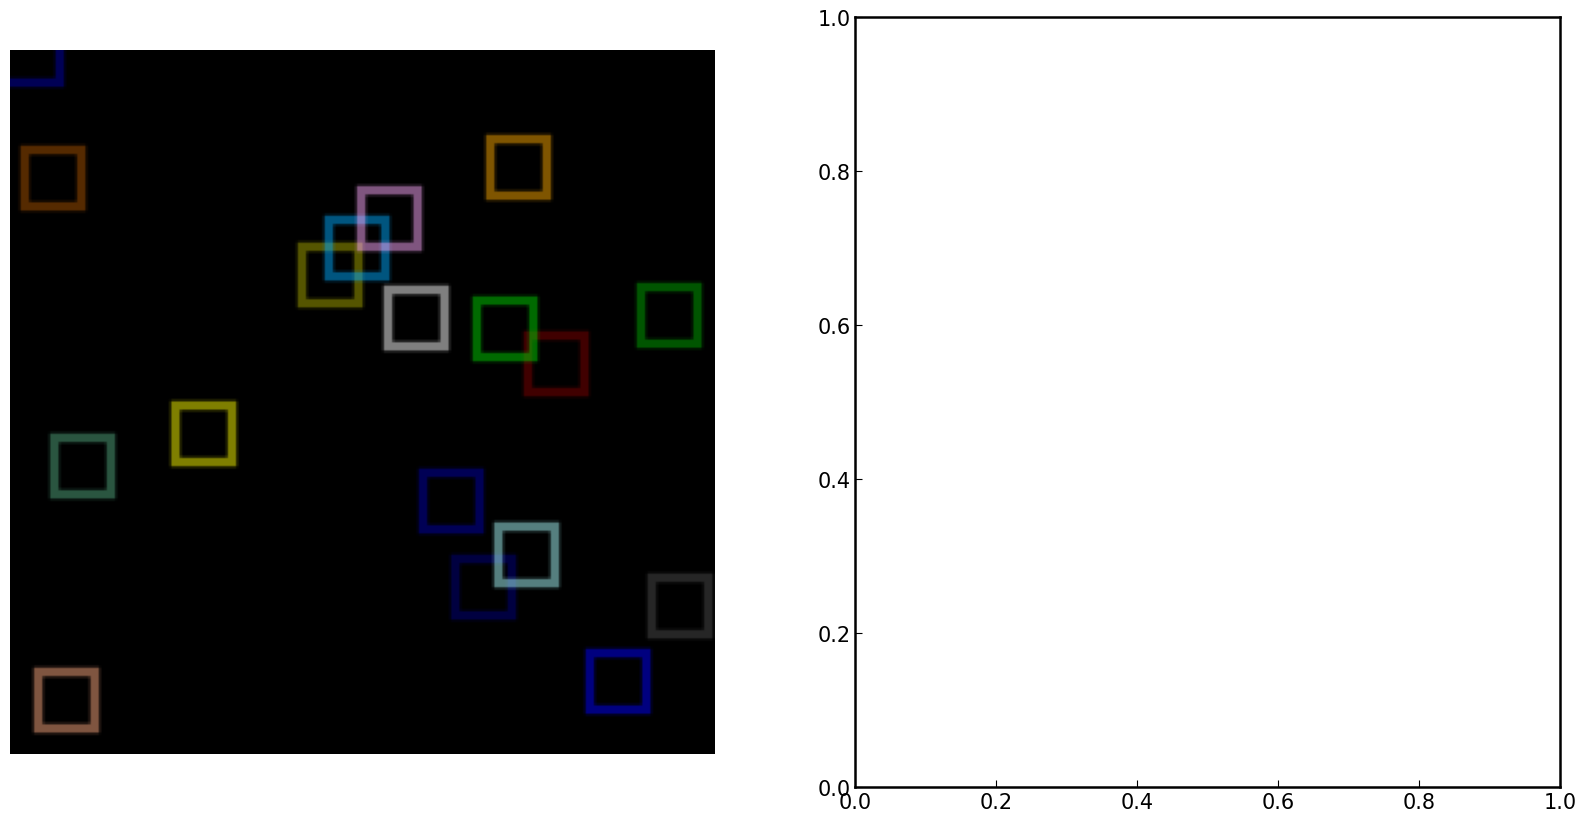

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10 * 2, 10))

d = random.sample(dataset_dicts["train"], 1)[0]

img = toolkit.read_image_decam(d["filename"])
visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis("off")

aug_d = train_mapper(d)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astro_metadata, scale=1)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d["instances"].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis("off")
fig.tight_layout()
fig.show()

### Training

We prepare for training by intializing a config object.  The we can take the intial weights from the pre-trained models in the model zoo.
This setup is for demo purposes, so it does not follow a full training schedule.

### Prepare For Training

We prepare for training by intializing a config object and setting hyperparameters.  The we can take the intial weights from the pre-trained models in the model zoo.  For a full list of available config options, check https://detectron2.readthedocs.io/en/latest/modules/config.html

This setup is for demo purposes, so it does not follow the full training schedule we use for the paper.  You can check the train_decam.py script for the final training configurations 

The model used here is not as good at transfer learning to astronomical images, so the results may not appear very good for the relatively short amount of iterations used here

In [10]:
cfgfile = '../configs/solo/wl_test.py'          # The config file which contains information about the model 
cfg = LazyConfig.load(cfgfile)                       # Load in the config
model = return_lazy_model(cfg,freeze=False)          # Build the model from the config specifications
cfg.optimizer.params.model = model                   # Set up the training optimizer
optimizer = return_optimizer(cfg)



loader = loaders.return_train_loader(cfg, train_mapper)      # Set up the loader, which formats the data to be fed into the model

schedulerHook = return_schedulerhook(optimizer)      # Create a "hook" which will set up the scheduler to control learning rates
saveHook = return_savehook("model_temp")             # Create a "hook" which will save the model
hookList = [saveHook, schedulerHook]                 

cfg.train.init_checkpoint = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"   #Initialize the model weights from a pre-trained model

cfg.OUTPUT_DIR ='./'                                 #Set the output directory





/home/wenyinli/miniforge3/envs/deepdisc_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /data/miniconda3/envs/opence-1.7/conda-bld/pytorch-base_1672876060819/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/14 15:55:32 d2.data.build]: Removed 0 images with no usable annotations. 256 images left.
[09/14 15:55:32 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   galaxy   | 5273         |
|            |              |
[09/14 15:55:32 d2.data.build]: Using training sampler TrainingSampler
[09/14 15:55:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/14 15:55:32 d2.data.common]: Serializing 256 elements to byte tensors and concatenating them all ...
[09/14 15:55:32 d2.data.common]: Serialized dataset takes 1.04 MiB
[09/14 15:55:32 d2.data.build]: Making batched data loader with batch_size=1


In [9]:
from deepdisc.training.trainers import (
    return_evallosshook,
    return_lazy_trainer,
    return_optimizer,
    return_savehook,
    return_schedulerhook,
)
from detectron2.config import LazyConfig


from deepdisc.model.models import return_lazy_model

import deepdisc.model.loaders as loaders
from deepdisc.data_format.image_readers import HSCImageReader

In [17]:
print(cfg['model']['roi_heads'].keys())

dict_keys(['num_classes', 'batch_size_per_image', 'positive_fraction', 'box_in_features', 'box_pooler', 'mask_in_features', 'mask_pooler', 'mask_head', '_target_', 'box_heads', 'box_predictors', 'proposal_matchers'])


Now we can train the model!  We set up a trainer and tell it how often to output and when to stop

In [1]:
#trainer = toolkit.NewAstroTrainer(model, loader, optimizer, cfg)
#trainer.register_hooks(hookList)
trainer = return_lazy_trainer(model, loader, optimizer, cfg, hookList)
trainer.set_period(50)  # print loss every 10 iterations
trainer.train(0, 1000)

NameError: name 'return_lazy_trainer' is not defined

In [59]:
# Hack if you get SSL certificate error
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import warnings

try:
    # ignore ShapelyDeprecationWarning from fvcore
    # This comes from the cropping
    from shapely.errors import ShapelyDeprecationWarning

    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

except:
    pass

In [14]:
from deepdisc.training.trainers import (
    return_evallosshook,
    return_lazy_trainer,
    return_optimizer,
    return_savehook,
    return_schedulerhook,
)
from detectron2.config import LazyConfig


from deepdisc.model.models import return_lazy_model

import deepdisc.model.loaders as loaders
from deepdisc.data_format.image_readers import HSCImageReader


### Plot The Loss

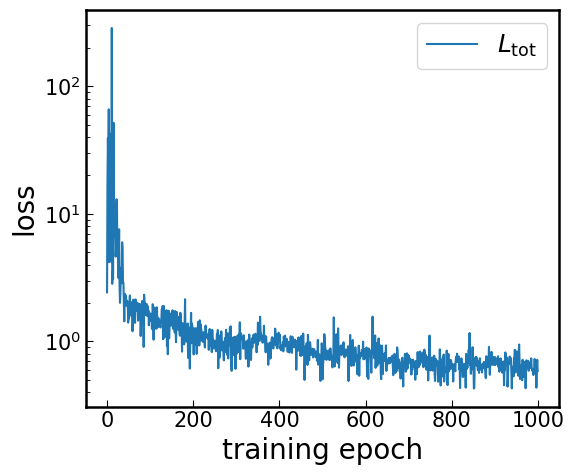

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(trainer.lossList, label=r"$L_{\rm{tot}}$")
# ax.plot(losses, label=r'$L_{\rm{tot}}$')

ax.legend(loc="upper right")
ax.set_xlabel("training epoch", fontsize=20)
ax.set_ylabel("loss", fontsize=20)
#ax.set_ylim(0,10)
ax.set_yscale('log')
fig.tight_layout()

### Inference

Inference should use the config with parameters that are used in training
cfg now already contains everything we've set previously. We changed it a little bit for inference:

In [27]:
cfgfile = '../configs/solo/wl_test.py'
cfg = LazyConfig.load(cfgfile)
cfg.OUTPUT_DIR = './'
cfg.train.init_checkpoint = os.path.join(cfg.OUTPUT_DIR, "model_temp.pth")

#change these to play with the detection sensitivity
model.roi_heads.box_predictor.test_score_thresh = 0.3
#model.roi_heads.box_predictor.test_nms_thresh = 0.5

predictor = toolkit.AstroPredictor(cfg)


[09/11 23:40:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./model_temp.pth ...


total instances: 17
detected instances: 11

total instances: 21
detected instances: 13

total instances: 26
detected instances: 25



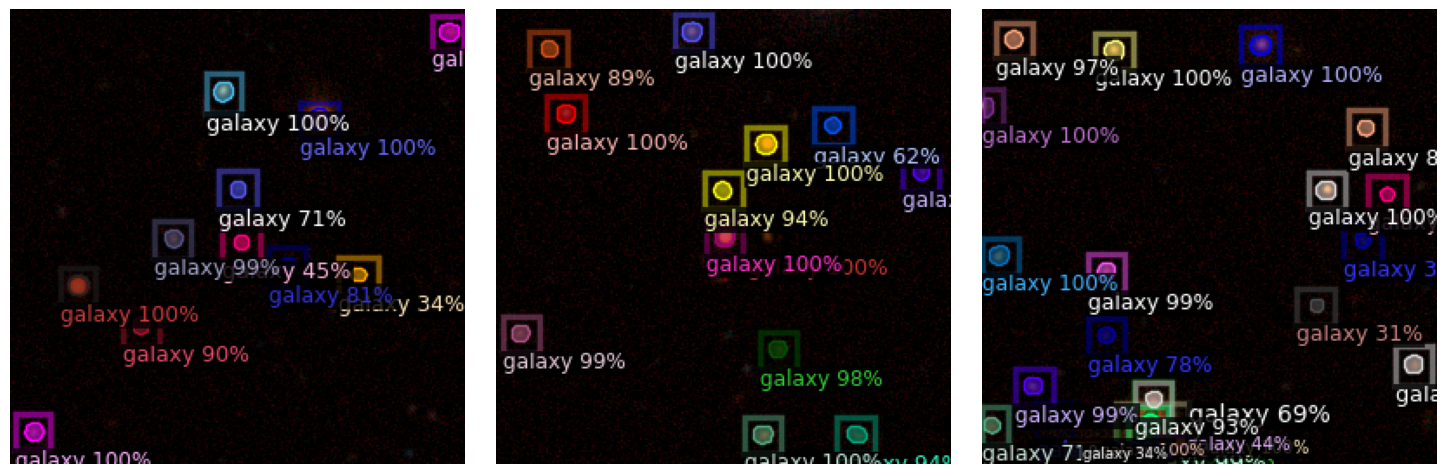

In [32]:
from detectron2.utils.visualizer import ColorMode

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5 * nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts["test"], nsample)):
    img = toolkit.read_image_decam(d["filename"], normalize="astrolupton", stretch=5, Q=1)
    outputs = predictor(
        img
    )  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    print("total instances:", len(d["annotations"]))
    print("detected instances:", len(outputs["instances"].pred_boxes))
    print("")

    v = Visualizer(
        img,
        metadata=astro_metadata,
        scale=1,
        instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis("off")
    fig.tight_layout()
    fig.show()

### Evaluate

In [41]:
def test_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = toolkit.read_image_decam(dataset_dict["file_name"], normalize="astrolupton", stretch=100, Q=10)
    augs = T.AugmentationList([])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
        # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
        "annotations": annos,
    }

In [48]:
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader

# NOTE: New version has max_dets_per_image argument in default COCOEvaluator
evaluator = toolkit.COCOEvaluatorRecall("astro_val", use_fast_impl=True, output_dir=cfg.OUTPUT_DIR)

test_loader = build_detection_test_loader(dataset_dicts["val"], mapper=test_mapper)

Loading  ./astro_val_coco_format.json
[09/02 21:53:40 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/02 21:53:40 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[09/02 21:53:40 d2.data.common]: Serialized dataset takes 0.32 MiB


In [49]:
results = inference_on_dataset(predictor.model, test_loader, evaluator)

[09/02 21:53:40 d2.evaluation.evaluator]: Start inference on 20 batches
[09/02 21:53:43 d2.evaluation.evaluator]: Inference done 11/20. Dataloading: 0.1228 s/iter. Inference: 0.0491 s/iter. Eval: 0.0223 s/iter. Total: 0.1941 s/iter. ETA=0:00:01
[09/02 21:53:45 d2.evaluation.evaluator]: Total inference time: 0:00:03.296987 (0.219799 s / iter per device, on 1 devices)
[09/02 21:53:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.049284 s / iter per device, on 1 devices)
()
_evaluate_predictions_on_coco
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
++++++++++ <class 'deepdisc.astrodet.astrodet.COCOeval_opt_custom'>
Running per image evaluation...
Evaluate annotation type *bbox*
[[0, 10000000000.0], [0, 1024], [1024, 9216], [9216, 10000000000.0]]
DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50   

In [50]:
results["bbox"]["AP-star"]

0.002357378595002357

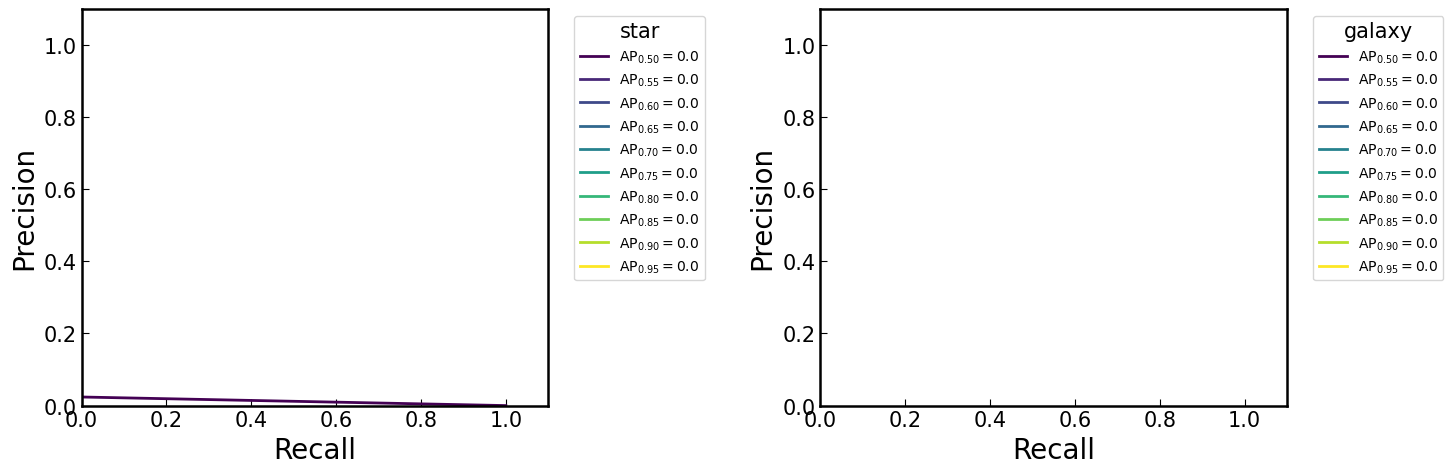

In [51]:
ap_type = "bbox"  # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ["star", "galaxy"]

results_per_category = results[ap_type]["results_per_category"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50, 0.95, 10)
colors = plt.cm.viridis(np.linspace(0, 1, len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = p_dat > 0
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p))  # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0]  # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100 * np.sum(p * dr)
        axs[j].plot(
            r, p, label=r"${\rm{AP}}_{%.2f} = %.1f$" % (iou, AP), color=colors[i], lw=2
        )  # use a viridis color scheme
        axs[j].set_xlabel("Recall", fontsize=20)
        axs[j].set_ylabel("Precision", fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f"{cls_names[j]}", bbox_to_anchor=(1.35, 1.0))

fig.tight_layout()

This demo is just to show how to set up the training.  We encourage you to add object classes, try different contrast scalings, and train for longer!  


    
  
  You can also look at the content of the output below  
  
  

In [ ]:
outputs = predictor(img)

In [ ]:
outputs['instances'].get_fields().keys()

In [ ]:
print(outputs['instances'].scores)